# Predicting Short-Term Price Movements of Top 10 Cryptocurrencies Using Historical OHLCV Data

![My Image](Images/Image.png)

## 1.0	Introduction & Objective
Cryptocurrency markets have become one of the most dynamic and volatile financial markets in recent years. Unlike traditional financial assets, cryptocurrencies operate in a decentralized environment, are traded continuously, and are heavily influenced by market sentiment, global events, and speculative behavior. These characteristics make cryptocurrency price movements highly unpredictable, yet extremely attractive for data-driven analysis.

The primary objective of this project is to predict the daily price direction of cryptocurrencies, specifically determining whether the price will increase (Up) or decrease (Down) on the next trading day based on historical market data. Instead of forecasting exact price values, this study focuses on directional movement, which is more practical for trading strategies and risk management.

By applying machine learning techniques such as Logistic Regression and Random Forest models, along with time-series–aware data splitting methods, this project seeks to evaluate whether historical price patterns and coin-specific features can provide meaningful signals for short-term price direction prediction.

Predicting cryptocurrency markets is particularly interesting because of their high volatility, rapid information flow, and non-stationary behavior. These factors present unique challenges for traditional modeling approaches and offer an opportunity to assess the effectiveness and limitations of machine learning models in real-world financial time-series forecasting.

In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report

## 2.0 First Approach

### 2.1	Load & Explore Data

In [2]:
# Path to your folder (edit this to your real folder)
path = r"C:\Users\USER\Desktop\Ada\Academics\3MTT\ADAP\Project\Top 10 Crypto Coins\File_1"

# Get all CSV files in the folder
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []   # list to hold dataframes

for file in all_files:
    df_one = pd.read_csv(file)

    # Extract coin name automatically from filename
    df_one["Coin"] = str(os.path.basename(file).replace(".csv", "")).upper()

    df_list.append(df_one)

# Combine all 10 files into one dataset
df = pd.concat(df_list, ignore_index=True)

# Sort by Date
df = df.sort_values(by="Date").reset_index(drop=True)

df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN


In [3]:
# Check the structure of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20232 entries, 0 to 20231
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      20232 non-null  object 
 1   Open      20232 non-null  float64
 2   High      20232 non-null  float64
 3   Low       20232 non-null  float64
 4   Close     20232 non-null  float64
 5   Volume    20232 non-null  float64
 6   Currency  20232 non-null  object 
 7   Coin      20232 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.2+ MB


In [4]:
# Checking for missing values
df.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
Coin        0
dtype: int64

In [5]:
# Checking for duplicates
df.duplicated().sum()

np.int64(0)

In [6]:
# Check the shape of the dataframe
df.shape

(20232, 8)

In [7]:
# Statistical summary
df.describe()

,Open,High,Low,Close,Volume
count,20232.000000,20232.000000,20232.000000,20232.000000,2.023200e+04
mean,1935.105446,1989.664673,1873.634025,1936.238051,6.157061e+08
std,7622.838028,7829.608468,7386.622541,7623.959307,3.037824e+09
min,0.000000,0.000793,0.000000,0.000774,0.000000e+00
25%,0.389979,0.403828,0.370555,0.390332,3.067898e+05
50%,10.169600,10.600000,9.755545,10.175000,7.893912e+06
75%,231.100000,237.800000,224.125000,231.287500,2.849378e+08
max,67528.700000,68990.600000,66334.900000,67527.900000,1.467988e+11


### 2.2	Data Cleaning & Preparation

In [8]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN


### 2.3	Feature Engineering & Target Creation

#### 2.3.1   Price-based features

In [9]:
# Creating Daily Returns Column
df['Daily_Return'] = df.groupby('Coin')['Close'].pct_change().round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0


In [10]:
#Creating High-low range column
df['HL_range'] = ((df['High'] - df['Low']) / df['Open']).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0


In [11]:
# 7-day rolling volatility of daily returns per coin
df['Volatility_7'] = df.groupby('Coin')['Daily_Return'].rolling(window=7).std().reset_index(0, drop=True).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN


#### 2.3.2    Moving averages & momentum

In [12]:
# Creating Moving Average (7 days and 14 days) of Closing Price per coin
df['MA_7'] = df.groupby('Coin')['Close'].transform(lambda x: x.rolling(window=7).mean()).round(2)
df['MA_14'] = df.groupby('Coin')['Close'].transform(lambda x: x.rolling(window=14).mean()).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN


In [13]:
# Creating Moving Average (7 days and 14 days) of Volume per coin
df['Volume_MA_7'] = df.groupby('Coin')['Volume'].transform(lambda x: x.rolling(window=7).mean()).round(2)
df['Volume_MA_14'] = df.groupby('Coin')['Volume'].transform(lambda x: x.rolling(window=14).mean()).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [14]:
# Creating Price vs moving average (7 days and 14 days) column
df['Close_MA7_ratio'] = (df['Close'] / df['MA_7']).round(2)
df['Close_MA14_ratio'] = (df['Close'] / df['MA_14']).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Creating Momentum Column as ratio: Close_t / Close_(t-7)
df['Momentum_7'] = df.groupby('Coin')['Close'].transform(lambda x: x / x.shift(7)).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3.3    Lag features

In [16]:
# Creating Return t-1 Column
df['Return_t1'] = df.groupby('Coin')['Daily_Return'].shift(1).round(2)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [17]:
# Creating Volume Change Column
df['Vol_Change'] = (df.groupby('Coin')['Volume'].pct_change(periods=1).round(2))
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.65
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.54
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.19
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.76


#### 2.3.4    Target Variable

In [18]:
# Define threshold 
threshold = 0.005  # 0.5%

# Create Target column with Up/Down based on threshold
df['Target'] = df.groupby('Coin')['Daily_Return'].shift(-1)  # Shift next day's daily return
df['Target'] = df['Target'].apply(lambda x: 1 if x > threshold else 0)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.65,0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.54,0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.19,0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.76,0


#### 2.3.5    Data Preparation for Training

In [19]:
# Drop rows with any NaN values created by rolling, lag, or shift operations
df = df.dropna().reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-31,0.1,0.1,0.1,0.1,4022.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3613.29,2274.14,1.0,1.0,1.0,0.0,0.33,0
1,2010-08-01,0.1,0.1,0.1,0.1,2601.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3763.29,2454.57,1.0,1.0,1.0,0.0,-0.35,0
2,2010-08-02,0.1,0.1,0.1,0.1,3599.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4152.14,2670.64,1.0,1.0,1.0,0.0,0.38,0
3,2010-08-03,0.1,0.1,0.1,0.1,9821.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,5073.14,3353.43,1.0,1.0,1.0,0.0,1.73,0
4,2010-08-04,0.1,0.1,0.1,0.1,3494.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4945.14,3561.93,1.0,1.0,1.0,0.0,-0.64,0


In [20]:
# Check for infinities
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Count infinities
inf_count = np.isinf(df[num_cols]).sum()

# Combine
problematic = pd.DataFrame({'Inf_count': inf_count})
print(problematic)

                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio        1210
Close_MA14_ratio       1205
Momentum_7                0
Return_t1                 0
Vol_Change               63
Target                    0


In [21]:
# Find rows with infinities or NaNs
rows_with_problems = df[np.isinf(df[num_cols]).any(axis=1) | df[num_cols].isna().any(axis=1)]
print(rows_with_problems)

            Date      Open      High       Low     Close        Volume  \
325   2011-06-26  17.50000  17.50000  14.00000  16.50000  1.505400e+04   
1647  2015-02-06   0.01573   0.01695   0.01400   0.01550  3.390000e+02   
1665  2015-02-21   0.01307   0.01410   0.01307   0.01307  1.000000e+00   
1671  2015-02-26   0.01400   0.01400   0.01160   0.01300  4.000000e+01   
1678  2015-03-03   0.00661   0.01205   0.00661   0.00850  5.601800e+04   
...          ...       ...       ...       ...       ...           ...   
14441 2021-01-15   0.31260   0.33100   0.27880   0.30250  1.360257e+09   
16232 2021-07-13   1.31470   1.32070   1.25070   1.26490  2.060775e+08   
16460 2021-08-04   1.36480   1.39300   1.32370   1.37590  3.251668e+08   
16689 2021-08-27   2.52950   2.94590   2.49920   2.94590  6.383809e+08   
16913 2021-09-21   2.06840   2.22390   1.91320   1.98300  7.953950e+08   

      Currency     Coin  Daily_Return  HL_range  ...   MA_7  MA_14  \
325        USD  BITCOIN         -0.06    

In [22]:
# Replace infinities with 0
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], 0)

# Recalculate infinity counts (should now be 0)
inf_count_cleaned = np.isinf(df[num_cols]).sum()

problematic = pd.DataFrame({'Inf_count': inf_count_cleaned})
print(problematic)

                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio           0
Close_MA14_ratio          0
Momentum_7                0
Return_t1                 0
Vol_Change                0
Target                    0


### 2.4     Train / Validation / Test Split (Time-Series Aware)

In [23]:
# Splitting features and target
x = df.drop(columns=['Date', 'Currency', 'Target'])
y = df['Target']
x.head()

,Open,High,Low,Close,Volume,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,0.1,0.1,0.1,0.1,4022.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,3613.29,2274.14,1.0,1.0,1.0,0.0,0.33
1,0.1,0.1,0.1,0.1,2601.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,3763.29,2454.57,1.0,1.0,1.0,0.0,-0.35
2,0.1,0.1,0.1,0.1,3599.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,4152.14,2670.64,1.0,1.0,1.0,0.0,0.38
3,0.1,0.1,0.1,0.1,9821.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,5073.14,3353.43,1.0,1.0,1.0,0.0,1.73
4,0.1,0.1,0.1,0.1,3494.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,4945.14,3561.93,1.0,1.0,1.0,0.0,-0.64


In [24]:
# Splitting into train and test sets
cutoff_date = '2021-06-13'

train_full = df[df['Date'] <= cutoff_date]
test = df[df['Date'] > cutoff_date]

# splitting train into train and validation sets
train_size = int(len(train_full) * 0.7)  # 70% of training for actual train
train = train_full.iloc[:train_size]
validation = train_full.iloc[train_size:]  # last 30% for validation

In [25]:
# Final feature and target sets
x_train = train[x.columns]
y_train = train['Target']

x_val = validation[x.columns]
y_val = validation['Target']

x_test = test[x.columns]
y_test = test['Target']

print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")
x_train.head()

Train shape: (11158, 18), Validation shape: (4783, 18), Test shape: (3999, 18)


,Open,High,Low,Close,Volume,Coin,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,0.1,0.1,0.1,0.1,4022.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,3613.29,2274.14,1.0,1.0,1.0,0.0,0.33
1,0.1,0.1,0.1,0.1,2601.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,3763.29,2454.57,1.0,1.0,1.0,0.0,-0.35
2,0.1,0.1,0.1,0.1,3599.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,4152.14,2670.64,1.0,1.0,1.0,0.0,0.38
3,0.1,0.1,0.1,0.1,9821.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,5073.14,3353.43,1.0,1.0,1.0,0.0,1.73
4,0.1,0.1,0.1,0.1,3494.0,BITCOIN,0.0,0.0,0.0,0.1,0.1,4945.14,3561.93,1.0,1.0,1.0,0.0,-0.64


In [26]:
# Scaling numerical features per coin using Min-Max Scaling
num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

scalers = {}

# ---- TRAIN: fit scaler per coin ----
for coin in x_train['Coin'].unique():
    scaler = MinMaxScaler()
    
    idx = x_train['Coin'] == coin
    x_train.loc[idx, num_cols] = scaler.fit_transform(
        x_train.loc[idx, num_cols]
    )
    
    scalers[coin] = scaler

# ---- VAL: transform using TRAIN scalers ----
for coin in x_val['Coin'].unique():
    if coin in scalers:
        idx = x_val['Coin'] == coin
        x_val.loc[idx, num_cols] = scalers[coin].transform(
            x_val.loc[idx, num_cols]
        )

# ---- TEST: transform using TRAIN scalers ----
for coin in x_test['Coin'].unique():
    if coin in scalers:
        idx = x_test['Coin'] == coin
        x_test.loc[idx, num_cols] = scalers[coin].transform(
            x_test.loc[idx, num_cols]
        )

print(x_train[num_cols].min(), x_train[num_cols].max())
print(x_val[num_cols].min(), x_val[num_cols].max())
print(x_test[num_cols].min(), x_test[num_cols].max())

Open                0.0
High                0.0
Low                 0.0
Close               0.0
Volume              0.0
Daily_Return        0.0
HL_range            0.0
Volatility_7        0.0
MA_7                0.0
MA_14               0.0
Volume_MA_7         0.0
Volume_MA_14        0.0
Close_MA7_ratio     0.0
Close_MA14_ratio    0.0
Momentum_7          0.0
Return_t1           0.0
Vol_Change          0.0
dtype: float64 Open                1.0
High                1.0
Low                 1.0
Close               1.0
Volume              1.0
Daily_Return        1.0
HL_range            1.0
Volatility_7        1.0
MA_7                1.0
MA_14               1.0
Volume_MA_7         1.0
Volume_MA_14        1.0
Close_MA7_ratio     1.0
Close_MA14_ratio    1.0
Momentum_7          1.0
Return_t1           1.0
Vol_Change          1.0
dtype: float64
Open               -0.005631
High               -0.002260
Low                -0.011667
Close              -0.005759
Volume             -0.004479
Daily_Ret

In [27]:
# One hot encoding for categorical variables
# One-hot encode coins only in X
x_train = pd.get_dummies(x_train, columns=['Coin'], drop_first=True, dtype=int)  # 0/1
x_val = pd.get_dummies(x_val, columns=['Coin'], drop_first=True, dtype=int)  # 0/1
x_test = pd.get_dummies(x_test, columns=['Coin'], drop_first=True, dtype=int)  # 0/1

# Align validation and test to train columns
x_val = x_val.reindex(columns=x_train.columns, fill_value=0)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)
x_train.head()

,Open,High,Low,Close,Volume,Daily_Return,HL_range,Volatility_7,MA_7,MA_14,...,Momentum_7,Return_t1,Vol_Change,Coin_BNB,Coin_CARDANO,Coin_DOGECOIN,Coin_ETHEREUM,Coin_LITECOIN,Coin_TETHER,Coin_XRP
0,0.0,0.0,0.000005,0.0,0.000261,0.14467,0.0,0.0,0.0,0.0,...,0.147638,0.14467,0.033493,0,0,0,0,0,0,0
1,0.0,0.0,0.000005,0.0,0.000169,0.14467,0.0,0.0,0.0,0.0,...,0.147638,0.14467,0.016369,0,0,0,0,0,0,0
2,0.0,0.0,0.000005,0.0,0.000233,0.14467,0.0,0.0,0.0,0.0,...,0.147638,0.14467,0.034752,0,0,0,0,0,0,0
3,0.0,0.0,0.000005,0.0,0.000637,0.14467,0.0,0.0,0.0,0.0,...,0.147638,0.14467,0.068748,0,0,0,0,0,0,0
4,0.0,0.0,0.000005,0.0,0.000226,0.14467,0.0,0.0,0.0,0.0,...,0.147638,0.14467,0.009066,0,0,0,0,0,0,0


### 2.5 Baseline Model

In [28]:
# Baseline 1: Naive “no-change” model
# Naive "no-change" prediction: tomorrow same as today
y_pred_baseline = y_test.shift(1)

# Drop the first row which cannot be predicted
y_test_masked = y_test[y_pred_baseline.notna()]
y_pred_baseline = y_pred_baseline[y_pred_baseline.notna()]

# Compute accuracy
naive_accuracy = (y_pred_baseline == y_test_masked).mean()
print("Naive baseline accuracy:", naive_accuracy)

Naive baseline accuracy: 0.7158579289644822


In [29]:
# Baseline 2: Always predict "Up"
y_pred_always_up = [1] * len(y_test)  # or len(df) if using full df

# Accuracy
always_up_accuracy = (y_pred_always_up == y_test).mean()
print("Always-up baseline accuracy:", always_up_accuracy)

Always-up baseline accuracy: 0.40335083770942737


### 2.6 Machine Learning Models

#### 2.6.1 Logistic Regression

In [30]:
# Logistic Regression Model
lr_model = LogisticRegression(C=1.0, max_iter=1000)
lr_model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [31]:
# Validate on VAL
val_pred = lr_model.predict(x_val)
val_acc = accuracy_score(y_val, val_pred)
print("Logistic Regression (VAL accuracy):", val_acc)

Logistic Regression (VAL accuracy): 0.5789253606523103


In [32]:
# Tuning using validation set
C_values = [0.01, 0.1, 1, 10]
best_c = None
best_acc = 0

for c in C_values:
    model = LogisticRegression(C=c, max_iter=1000)
    model.fit(x_train, y_train)
    acc = accuracy_score(y_val, model.predict(x_val))
    
    print(f"C={c}, Val Acc={acc}")
    
    if acc > best_acc:
        best_acc = acc
        best_c = c

print("Best C:", best_c)

C=0.01, Val Acc=0.577043696424838
C=0.1, Val Acc=0.5820614676980974
C=1, Val Acc=0.5789253606523103
C=10, Val Acc=0.5808070248797825
Best C: 0.1


In [33]:
# Train final model with best C on full training data (train + val)
lr_model = LogisticRegression(C=best_c, max_iter=1000)
lr_model.fit(x_train, y_train)

lrtest_pred = lr_model.predict(x_test)
lrtest_acc = accuracy_score(y_test, lrtest_pred)
print("Test accuracy:", lrtest_acc)

Test accuracy: 0.5933983495873969


In [34]:
# Evaluation Metrics
# --- Define directional accuracy ---
def directional_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# --- Metrics dictionary ---
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "Directional accuracy": directional_accuracy,  
}

# --- Compute metrics ---
results = {}
for name, func in metrics.items():
    lr_score = func(y_test, lrtest_pred)
    results[name] = {"Logistic Regression": lr_score}

# --- Compute confusion matrix separately ---
results["Confusion Matrix"] = {"Logistic Regression": confusion_matrix(y_test, lrtest_pred)}
# --- Convert metrics to pandas DataFrame ---
metrics_only = {k: v["Logistic Regression"] for k, v in results.items() if k != "Confusion Matrix"}
df_metrics = pd.DataFrame.from_dict(metrics_only, orient='index', columns=["Logistic Regression"])
df_metrics.index.name = "Metric"
df_metrics.reset_index(inplace=True)

print("=== Logistic Regression Metrics ===")
display(df_metrics)

# --- Convert confusion matrix to pandas DataFrame ---
cm = results["Confusion Matrix"]["Logistic Regression"]
df_cm = pd.DataFrame(cm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

print("\n=== Logistic Regression Confusion Matrix ===")
display(df_cm)

=== Logistic Regression Metrics ===


,Metric,Logistic Regression
0,Accuracy,0.593398
1,Precision,0.489600
2,Recall,0.189709
3,F1 Score,0.273458
4,Directional accuracy,0.593398



=== Logistic Regression Confusion Matrix ===


,Predicted 0,Predicted 1
Actual 0,2067,319
Actual 1,1307,306


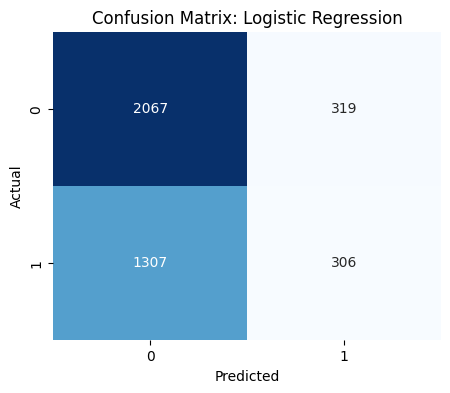

In [35]:
#   Visualizing Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, lrtest_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

#### 2.6.2 Random Forest Classifier

In [36]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
# Validate on VAL
rf_val_pred = rf_model.predict(x_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
print("Random Forest (VAL accuracy):", rf_val_acc)

Random Forest (VAL accuracy): 0.5776709178339954


In [38]:
# Tuning using validation set
depths = [3, 5, 10]
trees = [100, 200]

best_acc = 0

for d in depths:
    for n in trees:
        rf_model= RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            random_state=42
        )
        rf_model.fit(x_train, y_train)
        acc = accuracy_score(y_val, rf_model.predict(x_val))
        print(f"Depth={d}, Trees={n}, Val Acc={acc}")

Depth=3, Trees=100, Val Acc=0.5753711060004182
Depth=3, Trees=200, Val Acc=0.5753711060004182
Depth=5, Trees=100, Val Acc=0.5776709178339954
Depth=5, Trees=200, Val Acc=0.5776709178339954
Depth=10, Trees=100, Val Acc=0.5787162868492578
Depth=10, Trees=200, Val Acc=0.58143424628894


In [39]:
# Train final model with best params on full training data (train + val)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_model.fit(x_train, y_train)

rftest_pred = rf_model.predict(x_test)
rftest_acc = accuracy_score(y_test, rftest_pred)
print("Test accuracy:", rftest_acc)

Test accuracy: 0.5981495373843461


In [40]:
# Evaluation Metrics
# --- Define directional accuracy ---
def directional_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# --- Metrics dictionary ---
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "Directional accuracy": directional_accuracy,  
}

# --- Compute metrics ---
results = {}
for name, func in metrics.items():
    rf_score = func(y_test, rftest_pred)
    results[name] = {"Random Forest": rf_score}

# --- Compute confusion matrix separately ---
results["Confusion Matrix"] = {"Random Forest": confusion_matrix(y_test, rftest_pred)}

# --- Convert metrics to pandas DataFrame ---
metrics_only = {k: v["Random Forest"] for k, v in results.items() if k != "Confusion Matrix"}
df_metrics = pd.DataFrame.from_dict(metrics_only, orient='index', columns=["Random Forest"])
df_metrics.index.name = "Metric"
df_metrics.reset_index(inplace=True)

print("=== Random Forest Metrics ===")
display(df_metrics)

# --- Convert confusion matrix to pandas DataFrame ---
cm = results["Confusion Matrix"]["Random Forest"]
df_cm = pd.DataFrame(cm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

print("\n=== Random Forest Confusion Matrix ===")
display(df_cm)


=== Random Forest Metrics ===


,Metric,Random Forest
0,Accuracy,0.598150
1,Precision,0.562500
2,Recall,0.016739
3,F1 Score,0.032511
4,Directional accuracy,0.598150



=== Random Forest Confusion Matrix ===


,Predicted 0,Predicted 1
Actual 0,2365,21
Actual 1,1586,27


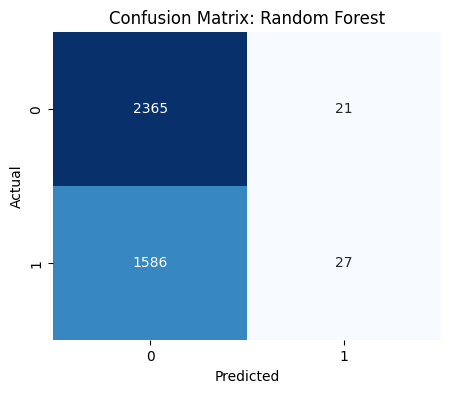

In [41]:
#   Visualizing Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, rftest_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.show()

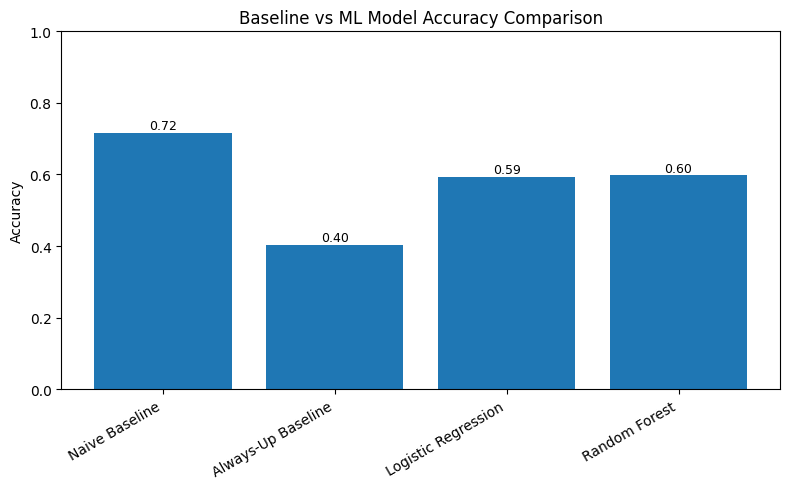

In [42]:
# Comparing Baseline and Model Accuracies
accuracy_data = {
    "Model": [
        "Naive Baseline",
        "Always-Up Baseline",
        "Logistic Regression",
        "Random Forest"
    ],
    "Accuracy": [
        naive_accuracy,
        always_up_accuracy,
        lrtest_acc,
        rftest_acc
    ]
}
df_acc = pd.DataFrame(accuracy_data)
df_acc

plt.figure(figsize=(8,5))
plt.bar(df_acc["Model"], df_acc["Accuracy"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Baseline vs ML Model Accuracy Comparison")
plt.xticks(rotation=30, ha="right")

# Add value labels
for i, v in enumerate(df_acc["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

## 3.0 Second Approach

### 3.1	Load & Explore Data

In [34]:
# Path to your folder (edit this to your real folder)
path = r"C:\Users\USER\Desktop\Ada\Academics\3MTT\ADAP\Project\Top 10 Crypto Coins\File_1"

# Get all CSV files in the folder
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []   # list to hold dataframes

for file in all_files:
    df_one = pd.read_csv(file)

    # Extract coin name automatically from filename
    df_one["Coin"] = str(os.path.basename(file).replace(".csv", "")).upper()

    df_list.append(df_one)

# Combine all 10 files into one dataset
df1 = pd.concat(df_list, ignore_index=True)

# Sort by Date
df1 = df1.sort_values(by="Date").reset_index(drop=True)

df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN


### 3.2	Data Cleaning & Preparation

In [35]:
# Convert 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'])
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN


### 3.3	Feature Engineering & Target Creation

#### 3.3.1   Price-based features

In [36]:
# Creating Daily Returns Column
df1['Daily_Return'] = df1.groupby('Coin')['Close'].pct_change()
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0


In [37]:
#Creating High-low range column
df1['HL_range'] = ((df1['High'] - df1['Low']) / df1['Open'])
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0


In [38]:
# Creating Open-Close range column
df1["OC_range"] = (df1["Close"] - df1["Open"]) / df1["Open"]
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0


In [39]:
# 7-day rolling volatility of daily returns per coin
df1["Volatility_7"] = (
    df1.groupby('Coin')['Daily_Return']
      .rolling(window=7, min_periods=7)
      .std()
      .reset_index(level=0, drop=True)
)
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN


#### 3.3.2    Moving averages & momentum

In [40]:
# Creating Moving Average (7 days $ 14 days) of Closing Price per coin
df1["MA_7"] = df1.groupby("Coin")["Close"].transform(lambda x: x.rolling(7, min_periods=7).mean())
df1["MA_14"] = df1.groupby("Coin")["Close"].transform(lambda x: x.rolling(14, min_periods=14).mean())
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN


In [41]:
# Creating Moving Average (7 days and 14 days) of Volume per coin
df1["Volume_MA_7"] = df1.groupby("Coin")["Volume"].transform(lambda x: x.rolling(7, min_periods=7).mean())
df1["Volume_MA_14"] = df1.groupby("Coin")["Volume"].transform(lambda x: x.rolling(14, min_periods=14).mean())
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [42]:
# Creating Price vs moving average (7 days and 14 days) column
df1["Close_MA7_ratio"] = df1["Close"] / df1["MA_7"]
df1["Close_MA14_ratio"] = df1["Close"] / df1["MA_14"]
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Creating Momentum Column as ratio: Close_t / Close_(t-7)
df1['Momentum_7'] = df1.groupby('Coin')['Close'].transform(lambda x: x / x.shift(7))
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.3.3    Lag features

In [44]:
# Creating Return t-1 Column
df1['Return_t1'] = df1.groupby('Coin')['Daily_Return'].shift(1).round(2)
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [45]:
# Creating Volume Change Column
df1['Vol_Change'] = (df1.groupby('Coin')['Volume'].pct_change(periods=1))
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.653333
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.543554
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.194656
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.756522


#### 3.3.4    Target Variable

In [46]:
df1["Next_Close"] = df1.groupby("Coin")["Close"].shift(-1)
df1["Target"] = (df1["Next_Close"] > df1["Close"]).astype(int)
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Next_Close,Target
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.653333,0.1,0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.543554,0.1,0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.194656,0.1,0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.756522,0.1,0


#### 3.3.5    Data Preparation for Training

In [47]:
# Drop helper column
df1 = df1.drop(columns=["Next_Close"])

# Drop rows with NaNs created by rolling/pct_change/shift
feature_cols = [
    "Open","High","Low","Close","Volume",
    "Daily_Return","HL_range","OC_range",
    "Volatility_7","MA_7","MA_14",
    "Volume_MA_7","Volume_MA_14",
    "Close_MA7_ratio","Close_MA14_ratio",
    "Coin"
]
# Drop rows with any NaN values created by rolling, lag, or shift operations
df1 = df1.dropna(subset=feature_cols + ["Target"]).reset_index(drop=True)
df1.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-31,0.1,0.1,0.1,0.1,4022.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3613.285714,2274.142857,1.0,1.0,1.0,0.0,0.331347,0
1,2010-08-01,0.1,0.1,0.1,0.1,2601.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3763.285714,2454.571429,1.0,1.0,1.0,0.0,-0.353307,0
2,2010-08-02,0.1,0.1,0.1,0.1,3599.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4152.142857,2670.642857,1.0,1.0,1.0,0.0,0.383699,0
3,2010-08-03,0.1,0.1,0.1,0.1,9821.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,5073.142857,3353.428571,1.0,1.0,1.0,0.0,1.728814,0
4,2010-08-04,0.1,0.1,0.1,0.1,3494.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4945.142857,3561.928571,1.0,1.0,1.0,0.0,-0.644232,0


In [48]:
# Check for infinities
num_cols = df1.select_dtypes(include=['int64', 'float64']).columns

# Count infinities
inf_count = np.isinf(df1[num_cols]).sum()

# Combine
problematic = pd.DataFrame({'Inf_count': inf_count})
print(problematic)


                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
OC_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio           0
Close_MA14_ratio          0
Momentum_7                0
Return_t1                 0
Vol_Change               63
Target                    0


In [49]:
# Find rows with infinities or NaNs
rows_with_problems = df1[np.isinf(df1[num_cols]).any(axis=1) | df1[num_cols].isna().any(axis=1)]
print(rows_with_problems)

            Date     Open     High      Low    Close        Volume Currency  \
325   2011-06-21  17.5000  17.5000  17.5000  17.5000  0.000000e+00      USD   
326   2011-06-22  17.5000  17.5000  17.5000  17.5000  0.000000e+00      USD   
327   2011-06-23  17.5000  17.5000  17.5000  17.5000  0.000000e+00      USD   
328   2011-06-24  17.5000  17.5000  17.5000  17.5000  0.000000e+00      USD   
329   2011-06-25  17.5000  17.5000  17.5000  17.5000  0.000000e+00      USD   
...          ...      ...      ...      ...      ...           ...      ...   
14603 2021-01-15   0.3126   0.3310   0.2788   0.3025  1.360257e+09      USD   
16394 2021-07-13   1.3147   1.3207   1.2507   1.2649  2.060775e+08      USD   
16622 2021-08-04   1.3648   1.3930   1.3237   1.3759  3.251668e+08      USD   
16851 2021-08-27   2.5295   2.9459   2.4992   2.9459  6.383809e+08      USD   
17075 2021-09-21   2.0684   2.2239   1.9132   1.9830  7.953950e+08      USD   

          Coin  Daily_Return  HL_range  ...       M

In [50]:
# Replace infinities with 0
df1[num_cols] = df1[num_cols].replace([np.inf, -np.inf], 0)

# Recalculate infinity counts (should now be 0)
inf_count_cleaned = np.isinf(df1[num_cols]).sum()

problematic = pd.DataFrame({'Inf_count': inf_count_cleaned})
print(problematic)

                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
OC_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio           0
Close_MA14_ratio          0
Momentum_7                0
Return_t1                 0
Vol_Change                0
Target                    0


### 3.4     Train / Validation / Test Split (Time-Series Aware)

In [51]:
x = df1.drop(columns=['Date', 'Currency', 'Target'])
y = df1['Target']
x.head()

,Open,High,Low,Close,Volume,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,0.1,0.1,0.1,0.1,4022.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,3613.285714,2274.142857,1.0,1.0,1.0,0.0,0.331347
1,0.1,0.1,0.1,0.1,2601.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,3763.285714,2454.571429,1.0,1.0,1.0,0.0,-0.353307
2,0.1,0.1,0.1,0.1,3599.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,4152.142857,2670.642857,1.0,1.0,1.0,0.0,0.383699
3,0.1,0.1,0.1,0.1,9821.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,5073.142857,3353.428571,1.0,1.0,1.0,0.0,1.728814
4,0.1,0.1,0.1,0.1,3494.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,4945.142857,3561.928571,1.0,1.0,1.0,0.0,-0.644232


In [52]:
# Splitting into train and test sets
cutoff_date = '2021-06-13'

train_full = df1[df1['Date'] <= cutoff_date]
test = df1[df1['Date'] > cutoff_date]

# splitting train into train and validation sets
train_size = int(len(train_full) * 0.7)  # 70% of training for actual train
train = train_full.iloc[:train_size]
validation = train_full.iloc[train_size:]  # last 30% for validation

In [53]:
# Splitting features and target for train, val, test
x_train = train[feature_cols].copy()
y_train = train["Target"].copy()

x_val = validation[feature_cols].copy()
y_val = validation["Target"].copy()

x_test = test[feature_cols].copy()
y_test = test["Target"].copy()

print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")
x_train.head()

Train shape: (11272, 16), Validation shape: (4831, 16), Test shape: (3999, 16)


,Open,High,Low,Close,Volume,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Coin
0,0.1,0.1,0.1,0.1,4022.0,0.0,0.0,0.0,0.0,0.1,0.1,3613.285714,2274.142857,1.0,1.0,BITCOIN
1,0.1,0.1,0.1,0.1,2601.0,0.0,0.0,0.0,0.0,0.1,0.1,3763.285714,2454.571429,1.0,1.0,BITCOIN
2,0.1,0.1,0.1,0.1,3599.0,0.0,0.0,0.0,0.0,0.1,0.1,4152.142857,2670.642857,1.0,1.0,BITCOIN
3,0.1,0.1,0.1,0.1,9821.0,0.0,0.0,0.0,0.0,0.1,0.1,5073.142857,3353.428571,1.0,1.0,BITCOIN
4,0.1,0.1,0.1,0.1,3494.0,0.0,0.0,0.0,0.0,0.1,0.1,4945.142857,3561.928571,1.0,1.0,BITCOIN


In [54]:
# Preprocessing pipeline
num_features = [c for c in feature_cols if c not in ["Coin"]]
cat_features = ["Coin"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

### 3.5 Baseline Model

In [55]:
# Baseline 1: Naive “no-change” model
# Naive "no-change" prediction: tomorrow same as today
y_pred_baseline = y_test.shift(1)

# Drop the first row which cannot be predicted
y_test_masked = y_test[y_pred_baseline.notna()]
y_pred_baseline = y_pred_baseline[y_pred_baseline.notna()]

# Compute accuracy
naive_accuracy = (y_pred_baseline == y_test_masked).mean()
print("Naive baseline accuracy:", naive_accuracy)

Naive baseline accuracy: 0.7208604302151076


In [56]:
# Baseline 2: Always predict "Up"
y_pred_always_up = [1] * len(y_test)  # or len(df) if using full df

# Accuracy
always_up_accuracy = (y_pred_always_up == y_test).mean()
print("Always-up baseline accuracy:", always_up_accuracy)

Always-up baseline accuracy: 0.48887221805451364


### 3.6 Machine Learning Model

#### 3.6.1 Pipeline Model

In [57]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
model.fit(x_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
# Validate on VAL
val_pred = model.predict(x_val)
Validation_acc = accuracy_score(y_val, val_pred)
print("Validation accuracy:", Validation_acc)

# Visualizing Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_val, val_pred)
df_cm = pd.DataFrame(
    cm,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print("\n=== Logistic Regression Confusion Matrix (VAL) ===")
display(df_cm)

# Generate classification report as dict
report_dict = classification_report(
    y_val,
    val_pred,
    output_dict=True,
    zero_division=0
)
# Convert to DataFrame
df_classification_report = pd.DataFrame(report_dict).transpose()

# Optional: round values for neat display
df_classification_report = df_classification_report.round(2)

print("\n=== Logistic Regression classification Report (VAL) ===")
df_classification_report

Validation accuracy: 0.5280480231836059

=== Logistic Regression Confusion Matrix (VAL) ===


,Predicted 0,Predicted 1
Actual 0,1037,1259
Actual 1,1021,1514



=== Logistic Regression classification Report (VAL) ===


,precision,recall,f1-score,support
0,0.50,0.45,0.48,2296.00
1,0.55,0.60,0.57,2535.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.52,0.52,0.52,4831.00
weighted avg,0.53,0.53,0.53,4831.00


In [59]:
# Test on TEST
test_pred = model.predict(x_test)
pltest_acc = accuracy_score(y_test, test_pred)
print("Test accuracy:", pltest_acc)

# Visualizing Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, test_pred)
df_cm = pd.DataFrame(
    cm,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print("\n=== Pipeline Logistic Regression Confusion Matrix (Test) ===")
display(df_cm)

# Generate classification report as dict
report_dict = classification_report(
    y_test,
    test_pred,
    output_dict=True,
    zero_division=0
)
# Convert to DataFrame
df_classification_report = pd.DataFrame(report_dict).transpose()

# Optional: round values for neat display
df_classification_report = df_classification_report.round(2)

print("\n=== Pipeline Logistic Regression classification Report (Test) ===")
df_classification_report

Test accuracy: 0.5371342835708928

=== Pipeline Logistic Regression Confusion Matrix (Test) ===


,Predicted 0,Predicted 1
Actual 0,1012,1032
Actual 1,819,1136



=== Pipeline Logistic Regression classification Report (Test) ===


,precision,recall,f1-score,support
0,0.55,0.50,0.52,2044.00
1,0.52,0.58,0.55,1955.00
accuracy,0.54,0.54,0.54,0.54
macro avg,0.54,0.54,0.54,3999.00
weighted avg,0.54,0.54,0.54,3999.00


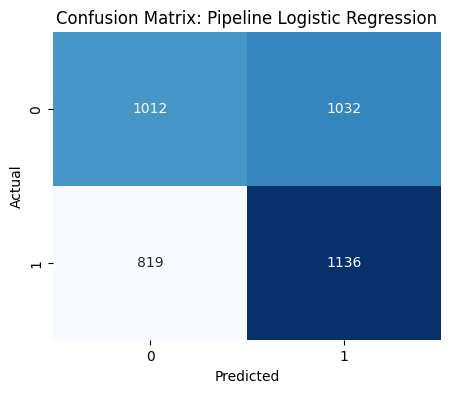

In [60]:
#   Visualizing Confusion Matrix for Pipeline Logistic Regression
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Pipeline Logistic Regression")
plt.show()

#### 3.6.2 Gradient Boosting Classifier Model

In [61]:
# Gradient Boosting Classifier Model
gb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", HistGradientBoostingClassifier(max_depth=6, learning_rate=0.05))
])
gb_model.fit(x_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
# Validate on VAL
gbval_pred = gb_model.predict(x_val)
Validation_acc = accuracy_score(y_val, gbval_pred)
print("Validation accuracy:", Validation_acc)

# Visualizing Confusion Matrix for Gradient Boosting
cm = confusion_matrix(y_val, gbval_pred)
df_cm = pd.DataFrame(
    cm,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print("\n=== Gradient Boosting Confusion Matrix (VAL) ===")
display(df_cm)

# Generate classification report as dict
report_dict = classification_report(
    y_val,
    gbval_pred,
    output_dict=True,
    zero_division=0
)
# Convert to DataFrame
df_classification_report = pd.DataFrame(report_dict).transpose()

# Optional: round values for neat display
df_classification_report = df_classification_report.round(2)

print("\n=== Gradient Boosting classification Report (VAL) ===")
df_classification_report

Validation accuracy: 0.5299109915131442

=== Gradient Boosting Confusion Matrix (VAL) ===


,Predicted 0,Predicted 1
Actual 0,1613,683
Actual 1,1588,947



=== Gradient Boosting classification Report (VAL) ===


,precision,recall,f1-score,support
0,0.50,0.70,0.59,2296.00
1,0.58,0.37,0.45,2535.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.54,0.54,0.52,4831.00
weighted avg,0.54,0.53,0.52,4831.00


In [63]:
# Test on TEST
gbtest_pred = gb_model.predict(x_test)
gbtest_acc = accuracy_score(y_test, gbtest_pred)
print("GB Test accuracy:", gbtest_acc)

# Visualizing Confusion Matrix for Gradient Boosting Classifier
cm = confusion_matrix(y_test, gbtest_pred)
df_cm = pd.DataFrame(
    cm,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print("\n=== Gradient Boosting Classifier (Test) ===")
display(df_cm)

# Generate classification report as dict
report_dict = classification_report(
    y_test,
    gbtest_pred,
    output_dict=True,
    zero_division=0
)
# Convert to DataFrame
df_classification_report = pd.DataFrame(report_dict).transpose()

# Optional: round values for neat display
df_classification_report = df_classification_report.round(2)

print("\n=== Gradient Boosting Classifier (Test) ===")
df_classification_report

GB Test accuracy: 0.5498874718679669

=== Gradient Boosting Classifier (Test) ===


,Predicted 0,Predicted 1
Actual 0,1357,687
Actual 1,1113,842



=== Gradient Boosting Classifier (Test) ===


,precision,recall,f1-score,support
0,0.55,0.66,0.60,2044.00
1,0.55,0.43,0.48,1955.00
accuracy,0.55,0.55,0.55,0.55
macro avg,0.55,0.55,0.54,3999.00
weighted avg,0.55,0.55,0.54,3999.00


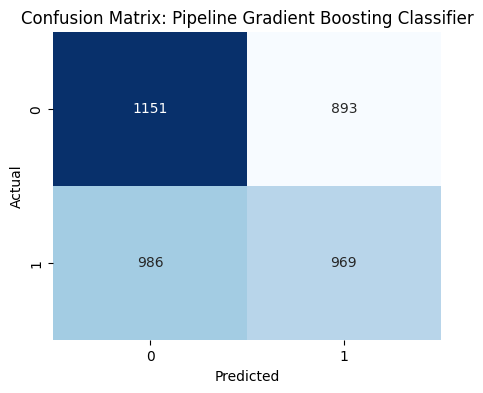

In [71]:
#   Visualizing Confusion Matrix for Pipeline Gradient Boosting Classifier
cm = confusion_matrix(y_test, gbtest_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Pipeline Gradient Boosting Classifier")
plt.show()

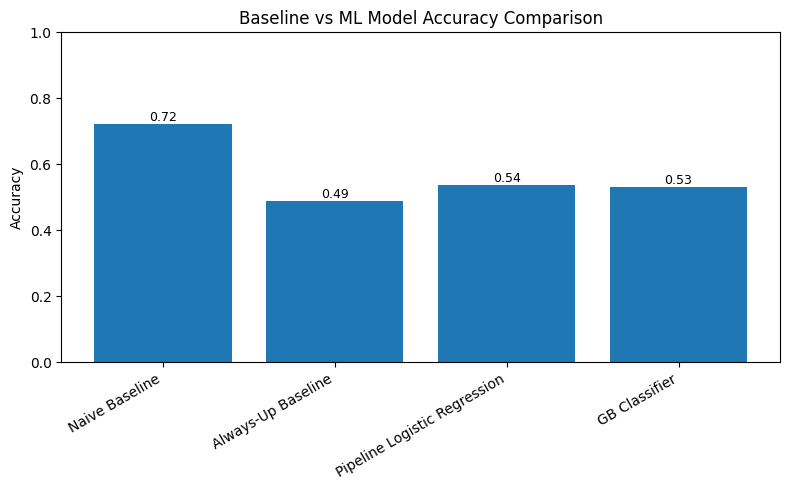

In [72]:
# Comparing Baseline and Model Accuracies
accuracy_data = {
    "Model": [
        "Naive Baseline",
        "Always-Up Baseline",
        "Pipeline Logistic Regression",
        "GB Classifier"
    ],
    "Accuracy": [
        naive_accuracy,
        always_up_accuracy,
        pltest_acc,
        gbtest_acc
    ]
}
df_acc = pd.DataFrame(accuracy_data)
df_acc

plt.figure(figsize=(8,5))
plt.bar(df_acc["Model"], df_acc["Accuracy"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Baseline vs ML Model Accuracy Comparison")
plt.xticks(rotation=30, ha="right")

# Add value labels
for i, v in enumerate(df_acc["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

## 4.0 Third Approach

### 4.1	Load & Explore Data

In [73]:
# Path to your folder (edit this to your real folder)
path = r"C:\Users\USER\Desktop\Ada\Academics\3MTT\ADAP\Project\Top 10 Crypto Coins\File_2"

# Get all CSV files in the folder
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []   # list to hold dataframes

for file in all_files:
    df_one = pd.read_csv(file)

    # Extract coin name automatically from filename
    df_one["Coin"] = str(os.path.basename(file).replace(".csv", "")).upper()

    df_list.append(df_one)

# Combine all 10 files into one dataset
df2 = pd.concat(df_list, ignore_index=True)

# Sort by Date
df2 = df2.sort_values(by="Date").reset_index(drop=True)

df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN


In [74]:
# Check the structure of the dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23664 entries, 0 to 23663
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      23664 non-null  object 
 1   Open      23664 non-null  float64
 2   High      23664 non-null  float64
 3   Low       23664 non-null  float64
 4   Close     23664 non-null  float64
 5   Volume    23664 non-null  float64
 6   Currency  23664 non-null  object 
 7   Coin      23664 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.4+ MB


In [75]:
# Checking for missing values
df2.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
Coin        0
dtype: int64

In [76]:
# Checking for duplicates
df2.duplicated().sum()

np.int64(0)

In [77]:
# Check the shape of the dataframe
df2.shape

(23664, 8)

In [78]:
# Statistical summary
df2.describe()

,Open,High,Low,Close,Volume
count,23664.000000,23664.000000,23664.000000,23664.000000,2.366400e+04
mean,1688.275744,1736.408601,1634.050837,1689.219003,5.842910e+08
std,7073.963254,7265.804979,6854.821795,7075.035020,2.826499e+09
min,0.000000,0.000793,0.000000,0.000774,0.000000e+00
25%,0.390332,0.412128,0.369905,0.390350,1.363102e+05
50%,56.055000,58.064000,54.057000,56.122673,1.119822e+07
75%,233.200000,240.620657,224.731750,233.432035,3.361009e+08
max,67528.700000,68990.600000,66334.900000,67527.900000,1.467988e+11


### 4.2	Data Cleaning & Preparation

In [79]:
# Convert 'Date' column to datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-31,0.1,0.1,0.1,0.1,4022.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3613.29,2274.14,1.0,1.0,1.0,0.0,0.33,0
1,2010-08-01,0.1,0.1,0.1,0.1,2601.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3763.29,2454.57,1.0,1.0,1.0,0.0,-0.35,0
2,2010-08-02,0.1,0.1,0.1,0.1,3599.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4152.14,2670.64,1.0,1.0,1.0,0.0,0.38,0
3,2010-08-03,0.1,0.1,0.1,0.1,9821.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,5073.14,3353.43,1.0,1.0,1.0,0.0,1.73,0
4,2010-08-04,0.1,0.1,0.1,0.1,3494.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4945.14,3561.93,1.0,1.0,1.0,0.0,-0.64,0


### 4.3	Feature Engineering & Target Creation

#### 4.3.1   Price-based features

In [80]:
# Creating Daily Returns Column
df2['Daily_Return'] = df2.groupby('Coin')['Close'].pct_change()
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0


In [81]:
#Creating High-low range column
df2['HL_range'] = ((df2['High'] - df2['Low']) / df2['Open'])
# Creating Open-Close range column
df2["OC_range"] = (df2["Close"] - df2["Open"]) / df2["Open"]
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0


In [82]:
# 7-day rolling volatility of daily returns per coin
df2["Volatility_7"] = (
    df2.groupby('Coin')['Daily_Return']
      .rolling(window=7, min_periods=7)
      .std()
      .reset_index(level=0, drop=True)
)
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN


#### 4.3.2    Moving averages & momentum

In [83]:
# Creating Moving Average (7 days $ 14 days) of Closing Price per coin
df2["MA_7"] = df.groupby("Coin")["Close"].transform(lambda x: x.rolling(7, min_periods=7).mean())
df2["MA_14"] = df.groupby("Coin")["Close"].transform(lambda x: x.rolling(14, min_periods=14).mean())
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN


In [84]:
# Creating Moving Average (7 days and 14 days) of Volume per coin
df2["Volume_MA_7"] = df2.groupby("Coin")["Volume"].transform(lambda x: x.rolling(7, min_periods=7).mean())
df2["Volume_MA_14"] = df2.groupby("Coin")["Volume"].transform(lambda x: x.rolling(14, min_periods=14).mean())
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [85]:
# Creating Price vs moving average (7 days and 14 days) column
df2["Close_MA7_ratio"] = df2["Close"] / df2["MA_7"]
df2["Close_MA14_ratio"] = df2["Close"] / df2["MA_14"]
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Creating Momentum Column as ratio: Close_t / Close_(t-7)
df2['Momentum_7'] = df2.groupby('Coin')['Close'].transform(lambda x: x / x.shift(7))
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.3.3    Lag features

In [87]:
# Creating Return t-1 Column
df2['Return_t1'] = df2.groupby('Coin')['Daily_Return'].shift(1)
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [88]:
# Creating Volume Change Column
df2['Vol_Change'] = (df2.groupby('Coin')['Volume'].pct_change(periods=1))
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.653333
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.543554
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.194656
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.756522


#### 4.3.4    Target Variable

In [89]:
# Define threshold 
threshold = 0.005  # 0.5%

# Create Target column with Up/Down based on threshold
df2['Target'] = df2.groupby('Coin')['Daily_Return'].shift(-1)  # Shift next day's daily return
df2['Target'] = df2['Target'].apply(lambda x: 1 if x > threshold else 0)
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-18,0.0,0.1,0.1,0.1,75.0,USD,BITCOIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2010-07-19,0.1,0.1,0.1,0.1,574.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.653333,0
2,2010-07-20,0.1,0.1,0.1,0.1,262.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.543554,0
3,2010-07-21,0.1,0.1,0.1,0.1,575.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.194656,0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,USD,BITCOIN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.756522,0


#### 4.3.5    Data Preparation for Training

In [90]:
# Drop rows with any NaN values created by rolling, lag, or shift operations
df2 = df2.dropna().reset_index(drop=True)
df2.head()

,Date,Open,High,Low,Close,Volume,Currency,Coin,Daily_Return,HL_range,...,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change,Target
0,2010-07-31,0.1,0.1,0.1,0.1,4022.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3613.285714,2274.142857,1.0,1.0,1.0,0.0,0.331347,0
1,2010-08-01,0.1,0.1,0.1,0.1,2601.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,3763.285714,2454.571429,1.0,1.0,1.0,0.0,-0.353307,0
2,2010-08-02,0.1,0.1,0.1,0.1,3599.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4152.142857,2670.642857,1.0,1.0,1.0,0.0,0.383699,0
3,2010-08-03,0.1,0.1,0.1,0.1,9821.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,5073.142857,3353.428571,1.0,1.0,1.0,0.0,1.728814,0
4,2010-08-04,0.1,0.1,0.1,0.1,3494.0,USD,BITCOIN,0.0,0.0,...,0.1,0.1,4945.142857,3561.928571,1.0,1.0,1.0,0.0,-0.644232,0


In [91]:
# Check for infinities
num_cols = df2.select_dtypes(include=['int64', 'float64']).columns

# Count infinities
inf_count = np.isinf(df2[num_cols]).sum()

# Combine
problematic = pd.DataFrame({'Inf_count': inf_count})
print(problematic)

                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
OC_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio           0
Close_MA14_ratio          0
Momentum_7                0
Return_t1                 0
Vol_Change              124
Target                    0


In [92]:
# Find rows with infinities or NaNs
rows_with_problems = df2[np.isinf(df2[num_cols]).any(axis=1) | df2[num_cols].isna().any(axis=1)]
print(rows_with_problems)

           Date        Open        High        Low       Close       Volume  \
325  2011-06-26   17.500000   17.500000   14.00000   16.500000      15054.0   
1641 2015-02-06    0.015730    0.016950    0.01400    0.015500        339.0   
1654 2015-02-17    0.520000    0.520000    0.01000    0.099000         70.0   
1657 2015-02-19    0.099000    0.350000    0.08900    0.260000        992.0   
1663 2015-02-21    0.013070    0.014100    0.01307    0.013070          1.0   
...         ...         ...         ...        ...         ...          ...   
4712 2017-06-05    0.039130    0.042080    0.03875    0.040550   40400132.0   
4715 2017-06-05   42.370000   48.060000   42.33000   47.990000      56591.0   
4961 2017-07-12    0.002197    0.002197    0.00174    0.001848    8909635.0   
5934 2017-11-27  464.000000  491.890000  458.25000  473.440000     671195.0   
6483 2018-01-22    1.396220    1.445130    1.17010    1.372430  315169344.0   

     Currency      Coin  Daily_Return  HL_range  ..

In [93]:
# Replace infinities with 0
df2[num_cols] = df2[num_cols].replace([np.inf, -np.inf], 0)

# Recalculate infinity counts (should now be 0)
inf_count_cleaned = np.isinf(df2[num_cols]).sum()

problematic = pd.DataFrame({'Inf_count': inf_count_cleaned})
print(problematic)

                  Inf_count
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Daily_Return              0
HL_range                  0
OC_range                  0
Volatility_7              0
MA_7                      0
MA_14                     0
Volume_MA_7               0
Volume_MA_14              0
Close_MA7_ratio           0
Close_MA14_ratio          0
Momentum_7                0
Return_t1                 0
Vol_Change                0
Target                    0


### 4.4     Train / Validation / Test Split (Time-Series Aware)

In [94]:
x = df2.drop(columns=['Date', 'Currency', 'Target'])
y = df2['Target']
x.head()

,Open,High,Low,Close,Volume,Coin,Daily_Return,HL_range,OC_range,Volatility_7,MA_7,MA_14,Volume_MA_7,Volume_MA_14,Close_MA7_ratio,Close_MA14_ratio,Momentum_7,Return_t1,Vol_Change
0,0.1,0.1,0.1,0.1,4022.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,3613.285714,2274.142857,1.0,1.0,1.0,0.0,0.331347
1,0.1,0.1,0.1,0.1,2601.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,3763.285714,2454.571429,1.0,1.0,1.0,0.0,-0.353307
2,0.1,0.1,0.1,0.1,3599.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,4152.142857,2670.642857,1.0,1.0,1.0,0.0,0.383699
3,0.1,0.1,0.1,0.1,9821.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,5073.142857,3353.428571,1.0,1.0,1.0,0.0,1.728814
4,0.1,0.1,0.1,0.1,3494.0,BITCOIN,0.0,0.0,0.0,0.0,0.1,0.1,4945.142857,3561.928571,1.0,1.0,1.0,0.0,-0.644232


In [95]:
# Splitting into train and test sets
cutoff_date = '2021-05-13'

train_full = df2[df2['Date'] <= cutoff_date]
test = df2[df2['Date'] > cutoff_date]

# splitting train into train and validation sets
train_size = int(len(train_full) * 0.7)  # 70% of training for actual train
train = train_full.iloc[:train_size]
validation = train_full.iloc[train_size:]  # last 30% for validation

In [96]:
# Final feature and target sets
x_train = train[x.columns]
y_train = train['Target']

x_val = validation[x.columns]
y_val = validation['Target']

x_test = test[x.columns]
y_test = test['Target']

print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")

Train shape: (12971, 19), Validation shape: (5559, 19), Test shape: (943, 19)


In [97]:
# Scaling numerical features per coin using Min-Max Scaling
num_cols = x.select_dtypes(include=['int64', 'float64']).columns

scalers = {}

# ---- TRAIN: fit scaler per coin ----
for coin in x_train['Coin'].unique():
    scaler = MinMaxScaler()
    
    idx = x_train['Coin'] == coin
    x_train.loc[idx, num_cols] = scaler.fit_transform(
        x_train.loc[idx, num_cols]
    )
    
    scalers[coin] = scaler

# ---- VAL: transform using TRAIN scalers ----
for coin in x_val['Coin'].unique():
    if coin in scalers:
        idx = x_val['Coin'] == coin
        x_val.loc[idx, num_cols] = scalers[coin].transform(
            x_val.loc[idx, num_cols]
        )

# ---- TEST: transform using TRAIN scalers ----
for coin in x_test['Coin'].unique():
    if coin in scalers:
        idx = x_test['Coin'] == coin
        x_test.loc[idx, num_cols] = scalers[coin].transform(
            x_test.loc[idx, num_cols]
        )

print(x_train[num_cols].min(), x_train[num_cols].max())
print(x_val[num_cols].min(), x_val[num_cols].max())
print(x_test[num_cols].min(), x_test[num_cols].max())

Open                0.0
High                0.0
Low                 0.0
Close               0.0
Volume              0.0
Daily_Return        0.0
HL_range            0.0
OC_range            0.0
Volatility_7        0.0
MA_7                0.0
MA_14               0.0
Volume_MA_7         0.0
Volume_MA_14        0.0
Close_MA7_ratio     0.0
Close_MA14_ratio    0.0
Momentum_7          0.0
Return_t1           0.0
Vol_Change          0.0
dtype: float64 Open                1.0
High                1.0
Low                 1.0
Close               1.0
Volume              1.0
Daily_Return        1.0
HL_range            1.0
OC_range            1.0
Volatility_7        1.0
MA_7                1.0
MA_14               1.0
Volume_MA_7         1.0
Volume_MA_14        1.0
Close_MA7_ratio     1.0
Close_MA14_ratio    1.0
Momentum_7          1.0
Return_t1           1.0
Vol_Change          1.0
dtype: float64
Open               -1.329205e-02
High               -1.367761e-02
Low                -1.779435e-02
Close  

In [98]:
# One hot encoding for categorical variables
# One-hot encode coins only in X
encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)
x_train = encoder.fit_transform(x_train[["Coin"]])
x_val = encoder.transform(x_val[["Coin"]])
x_test = encoder.transform(x_test[["Coin"]])

### 4.5 Baseline Model

In [99]:
# Baseline 1: Naive “no-change” model
# Naive "no-change" prediction: tomorrow same as today
y_pred_baseline = y_test.shift(1)

# Drop the first row which cannot be predicted
y_test_masked = y_test[y_pred_baseline.notna()]
y_pred_baseline = y_pred_baseline[y_pred_baseline.notna()]

# Compute accuracy
naive_accuracy = (y_pred_baseline == y_test_masked).mean()
print("Naive baseline accuracy:", naive_accuracy)

Naive baseline accuracy: 0.7547770700636943


In [100]:
# Baseline 2: Always predict "Up"
y_pred_always_up = [1] * len(y_test)  # or len(df) if using full df

# Accuracy
always_up_accuracy = (y_pred_always_up == y_test).mean()
print("Always-up baseline accuracy:", always_up_accuracy)

Always-up baseline accuracy: 0.46553552492046657


### 4.6 Machine Learning Models

In [101]:
# Logistic Regression Model
lr_model = LogisticRegression(C=1.0, max_iter=1000)
lr_model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [102]:
# Validate on VAL
val_pred = lr_model.predict(x_val)
val_acc = accuracy_score(y_val, val_pred)
print("Logistic Regression (VAL accuracy):", val_acc)

Logistic Regression (VAL accuracy): 0.5349883072495053


In [103]:
# Tuning using validation set
C_values = [0.01, 0.1, 1, 10]
best_c = None
best_acc = 0

for c in C_values:
    model = LogisticRegression(C=c, max_iter=1000)
    model.fit(x_train, y_train)
    acc = accuracy_score(y_val, model.predict(x_val))
    
    print(f"C={c}, Val Acc={acc}")
    
    if acc > best_acc:
        best_acc = acc
        best_c = c

print("Best C:", best_c)

C=0.01, Val Acc=0.5349883072495053
C=0.1, Val Acc=0.5349883072495053
C=1, Val Acc=0.5349883072495053
C=10, Val Acc=0.5349883072495053
Best C: 0.01


In [104]:
# Train final model with best C on full training data
lr_model = LogisticRegression(C=best_c, max_iter=1000)
lr_model.fit(x_train, y_train)

test_pred = lr_model.predict(x_test)
test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy:", test_acc)

Test accuracy: 0.5344644750795334


In [105]:

# Evaluation Metrics
# --- Define directional accuracy ---
def directional_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# --- Metrics dictionary ---
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "Directional accuracy": directional_accuracy,  
}

# --- Compute metrics ---
results = {}
for name, func in metrics.items():
    lr_score = func(y_test, test_pred)
    results[name] = {"Logistic Regression": lr_score}

# --- Compute confusion matrix separately ---
results["Confusion Matrix"] = {"Logistic Regression": confusion_matrix(y_test, test_pred)}

# --- Convert metrics to pandas DataFrame ---
metrics_only = {k: v["Logistic Regression"] for k, v in results.items() if k != "Confusion Matrix"}
df_metrics = pd.DataFrame.from_dict(metrics_only, orient='index', columns=["Logistic Regression"])
df_metrics.index.name = "Metric"
df_metrics.reset_index(inplace=True)

print("=== Logistic Regression Metrics ===")
display(df_metrics)

# --- Convert confusion matrix to pandas DataFrame ---
cm = results["Confusion Matrix"]["Logistic Regression"]
df_cm = pd.DataFrame(cm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

print("\n=== Logistic Regression Confusion Matrix ===")
display(df_cm)


=== Logistic Regression Metrics ===


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Metric,Logistic Regression
0,Accuracy,0.534464
1,Precision,0.000000
2,Recall,0.000000
3,F1 Score,0.000000
4,Directional accuracy,0.534464



=== Logistic Regression Confusion Matrix ===


,Predicted 0,Predicted 1
Actual 0,504,0
Actual 1,439,0


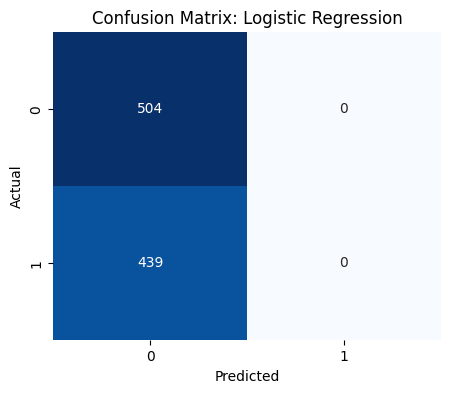

In [106]:
#   Visualizing Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

In [107]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [108]:
# Validate on VAL
rf_val_pred = rf_model.predict(x_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
print("Random Forest (VAL accuracy):", rf_val_acc)

Random Forest (VAL accuracy): 0.5349883072495053


In [109]:
# Tuning using validation set
depths = [3, 5, 10]
trees = [100, 200]

best_acc = 0

for d in depths:
    for n in trees:
        rf_model= RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            random_state=42
        )
        rf_model.fit(x_train, y_train)
        acc = accuracy_score(y_val, rf_model.predict(x_val))
        print(f"Depth={d}, Trees={n}, Val Acc={acc}")

Depth=3, Trees=100, Val Acc=0.5349883072495053
Depth=3, Trees=200, Val Acc=0.5349883072495053
Depth=5, Trees=100, Val Acc=0.5349883072495053
Depth=5, Trees=200, Val Acc=0.5349883072495053
Depth=10, Trees=100, Val Acc=0.5349883072495053
Depth=10, Trees=200, Val Acc=0.5349883072495053


In [110]:
# Train final model with best params on full training data
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_model.fit(x_train, y_train)

rftest_pred = rf_model.predict(x_test)
rftest_acc = accuracy_score(y_test, rftest_pred)
print("Test accuracy:", rftest_acc)

Test accuracy: 0.5344644750795334


In [111]:
# Evaluation Metrics
# --- Define directional accuracy ---
def directional_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# --- Metrics dictionary ---
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "Directional accuracy": directional_accuracy,  
}

# --- Compute metrics ---
results = {}
for name, func in metrics.items():
    rf_score = func(y_test, rftest_pred)
    results[name] = {"Random Forest": rf_score}

# --- Compute confusion matrix separately ---
results["Confusion Matrix"] = {"Random Forest": confusion_matrix(y_test, rftest_pred)}

# --- Convert metrics to pandas DataFrame ---
metrics_only = {k: v["Random Forest"] for k, v in results.items() if k != "Confusion Matrix"}
df_metrics = pd.DataFrame.from_dict(metrics_only, orient='index', columns=["Random Forest"])
df_metrics.index.name = "Metric"
df_metrics.reset_index(inplace=True)

print("=== Random Forest Metrics ===")
display(df_metrics)

# --- Convert confusion matrix to pandas DataFrame ---
cm = results["Confusion Matrix"]["Random Forest"]
df_cm = pd.DataFrame(cm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

print("\n=== Random Forest Confusion Matrix ===")
display(df_cm)


=== Random Forest Metrics ===


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Metric,Random Forest
0,Accuracy,0.534464
1,Precision,0.000000
2,Recall,0.000000
3,F1 Score,0.000000
4,Directional accuracy,0.534464



=== Random Forest Confusion Matrix ===


,Predicted 0,Predicted 1
Actual 0,504,0
Actual 1,439,0


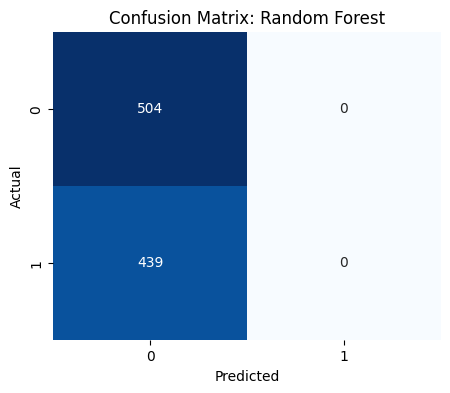

In [112]:
#   Visualizing Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, rftest_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.show()

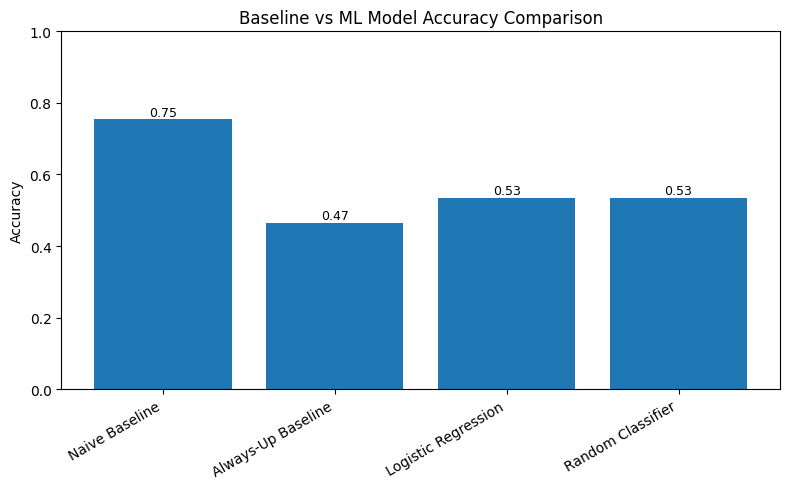

In [113]:
# Comparing Baseline and Model Accuracies
accuracy_data = {
    "Model": [
        "Naive Baseline",
        "Always-Up Baseline",
        "Logistic Regression",
        "Random Classifier"
    ],
    "Accuracy": [
        naive_accuracy,
        always_up_accuracy,
        test_acc,
        rftest_acc
    ]
}
df_acc = pd.DataFrame(accuracy_data)
df_acc

plt.figure(figsize=(8,5))
plt.bar(df_acc["Model"], df_acc["Accuracy"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Baseline vs ML Model Accuracy Comparison")
plt.xticks(rotation=30, ha="right")

# Add value labels
for i, v in enumerate(df_acc["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()